In [94]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from random import choice
from datetime import datetime

from read import read_sims_result
from clean import cleanup_network,cleanup_0IR_exp

from matplotlib.animation import FuncAnimation

In [96]:
df = read_sims_result('/Users/xcheng/Documents/Oberlin/Summer2/DataAnalysis/data/0614/1IR', 32)
df_1n = cleanup_network(df, numNode=32, numPeriod=15, numSim=50)
df_1c = cleanup_0IR_exp(df, numNode=32, numPeriod=15, numSim=50, balanced=False)

In [103]:
df.columns
# df_1c.columns

Index(['dot0', 'dot1', 'dot2', 'dot3', 'dot4', 'dot5', 'dot6', 'dot7', 'dot8',
       'dot9', 'dot10', 'dot11', 'dot12', 'dot13', 'dot14', 'dot15', 'dot16',
       'dot17', 'dot18', 'dot19', 'dot20', 'dot21', 'dot22', 'dot23', 'dot24',
       'dot25', 'dot26', 'dot27', 'dot28', 'dot29', 'dot30', 'period',
       'theta (risk aversion)', 'defaults due to interest',
       'defaults due to negative wealth', 'defaults due to deposit shock',
       'over leverages', 'wealth', 'debt to pay', 'credit available',
       'debt owed', 'credit issued', 'deposits', 'cash', 'assets', 'sim#',
       'bankID'],
      dtype='object')

In [115]:
a=(4,5)
print(list(a))
a

[4, 5]


(4, 5)

In [120]:
foo = set([3,4,5])
foo.remove(0)
foo

KeyError: 0

In [22]:
def update_edge_matrix(g, ndarray):
    for i in range(len(ndarray)):
        for j in range(len(ndarray)):
            g.add_edge(i, j, weight=ndarray[i][j])

In [177]:
df[np.array(df["sim#"]==10) &
   np.array(df["period"]==15) &
   np.array(df["bankID"]==1)].loc[:,"dot30":]

,dot30,period,theta (risk aversion),defaults due to interest,defaults due to negative wealth,defaults due to deposit shock,over leverages,wealth,debt to pay,credit available,debt owed,credit issued,deposits,cash,assets,sim#,bankID
5085,0.0,15,0.1,0,1,0,7,0.0,0.0,0.0,0.0,25.5389,1003.69,0.0,87.3115,10,1


In [178]:
a,b,c= df[np.array(df["sim#"]==10) &
   np.array(df["period"]==15) &
   np.array(df["bankID"]==1)
  ].iloc[0]["defaults due to interest":"defaults due to deposit shock"]
print(a,b,c)
#.loc[:,"defaults due to interest":"defaults due to deposit shock"]

0.0 1.0 0.0


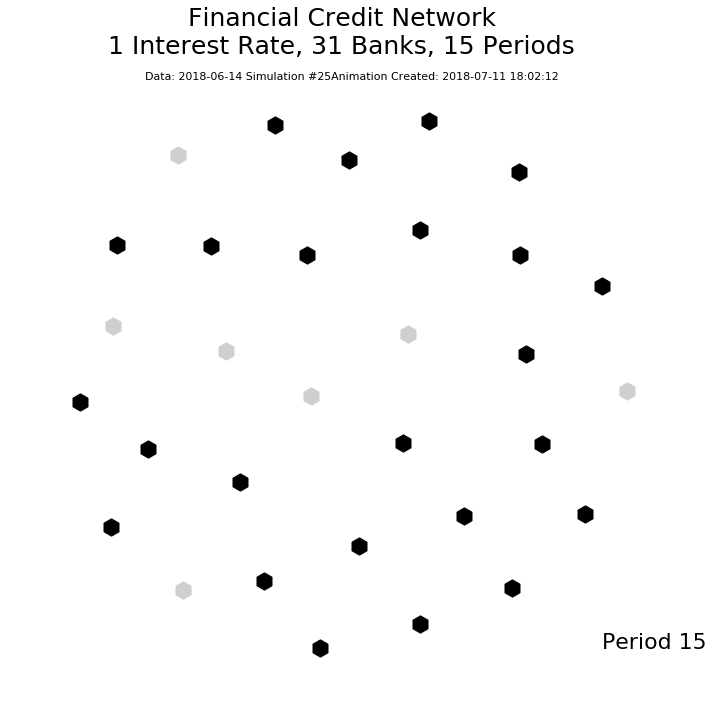

In [198]:
########################
# Variables you can manipulate
########################
data_birthday = "2018-06-14"
data_info = "1 Interest Rate, 31 Banks, 15 Periods"
sim_num = 25

########################
# Make BETTER video
########################
# Get current time
time_creation = datetime.now()
time_displayed = time_creation.strftime('%Y-%m-%d %H:%M:%S')
time_filename = time_creation.strftime("%Y%m%dT%H%M%S")

# make a full graph
fully_connected=np.ones((31,31))
for i in range(31):
    fully_connected[i,i] = 0
G = nx.DiGraph(fully_connected)

# make the canvas
fig = plt.figure(figsize=(11,11))
plt.suptitle("Financial Credit Network\n"+data_info, fontsize=25)
period = plt.text(s="o", x=0.91, y=-0.99, fontsize=22)
plt.title(fontsize=11, 
          s=("Data: " + data_birthday
            + " Simulation #" + str(sim_num)
            + "Animation Created: " + time_displayed
            ) 
         )
plt.axis('off')
pos=nx.spring_layout(G) 

# keep track of banks still alive
alive_banks = set(range(31))
# keep track of banks last dead
last_dead = set([])

# draw the nodes
for n in G:
    G.node[n]['draw'] = nx.draw_networkx_nodes(G,
                                               pos,
                                               nodelist=[n], 
                                               with_labels=False, 
                                               node_color= (0,0,0),
                                               node_shape= "h"
                                              )
    
    # for u,v in G.edges():
    #     G[u][v]['draw']=nx.draw_networkx_edges(G,pos,edgelist=[(u,v)],edge_color="white",arrows=True)
    # edges = nx.draw_networkx_edges(G, pos, arrows=False, edge_color="white")

#     return [node[1] for node in G.nodes(data="draw")]

    
def update(i):
#     update_edge_matrix(G, df.loc[i*31:i*31+30, "dot1":"dot31"].values)
#     positive_edges = [[u,v] for (u,v,d) in G.edges(data=True) if d['weight'] >0]
#     print(positive_edges)
#     edges = nx.draw_networkx_edges(G, pos, arrows=False,edgelist=positive_edges) 
#     print(edges.get_array())

#     nodes = nx.draw_networkx_nodes(G, pos, nodelist=list(choice(G.nodes())), node_color="b")
    
    # if the bank default last period, change the color
    for dead in last_dead:
        G.node[dead]['draw'].set_color((0.81,0.81,0.81))
    last_dead.clear()
    
    # if the bank defaults, change the color, mark as dead
    for bank in list(alive_banks):
        
        interest, wealth, deposit = df[np.array(df["sim#"]==sim_num) &
                                       np.array(df["period"]==(i+1)) &
                                       np.array(df["bankID"]==bank)
                                      ].iloc[0]["defaults due to interest":"defaults due to deposit shock"]
        
        if interest + wealth + deposit != 0:
            alive_banks.remove(bank)
            last_dead.add(bank)
        if interest != 0:
            G.node[bank]['draw'].set_color((0.99,0.00,0.02))
        if wealth != 0:
            G.node[bank]['draw'].set_color((0.59,0.00,0.02))
        if deposit != 0:
            G.node[bank]['draw'].set_color((0.99,0.00,0.49))
            

    # update the text (period)
    period.set_text("Period "+str(i+1))

    return [node[1] for node in G.nodes(data="draw")]+[period]

anim = FuncAnimation(fig, update, frames=15, interval=800, repeat=False, blit=True)
anim.save("network" + time_filename + ".mp4")

In [48]:
########################
# Make video
########################

G = nx.DiGraph()
update_edge_matrix(G, df.loc[31:31+30, "dot1":"dot31"].values)

fig = plt.figure(figsize=(10,10))
pos=nx.spring_layout(G) 

positive_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0]
nodes = nx.draw_networkx_nodes(G, pos)
edges = nx.draw_networkx_edges(G, pos, arrows=False, edgelist=positive_edges) 
plt.axis('off')

def update(i):
    update_edge_matrix(G, df.loc[i*31:i*31+30, "dot1":"dot31"].values)
    positive_edges = [[u,v] for (u,v,d) in G.edges(data=True) if d['weight'] >0]
#     print(positive_edges)
    edges = nx.draw_networkx_edges(G, pos, arrows=False,edgelist=positive_edges) 
#     print(edges.get_array())
    return edges,

anim = FuncAnimation(fig, update, frames=range(2,5), interval=500, blit=True)
anim.save("network.mp4")

NameError: name 'update_edge_matrix' is not defined

In [76]:
########################
# Draw pictures and stitch 
########################

# G = nx.DiGraph()
# update_edge_matrix(G, df.loc[0:30, "dot1":"dot31"].values)
# pos=nx.spring_layout(G) 
# for i in range(15):
#     update_edge_matrix(G, df.loc[0:30, "dot1":"dot31"].values)

#     fig = plt.figure(figsize=(10,10))
#     plt.axis('off')
#     nx.draw_networkx_nodes(G,pos)
    
#     update_edge_matrix(G, df.loc[i*31:i*31+30, "dot1":"dot31"].values)
#     positive_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0]
#     nx.draw_networkx_edges(G, pos, arrows=True, edgelist=positive_edges) 
#     plt.text(-0.95,0.95,s="period "+str(i+1),fontsize=24)
#     plt.savefig("zzp-fig"+str(i)+".png")